# Projeto de descrição e detecção de fraudes em banco de dados de transações em cartão de crédito

O banco é disponibilizado pela plataforma Kaggle:
https://www.kaggle.com/mlg-ulb/creditcardfraud

Para contexto, o banco apresenta transações de cartão de credito de dois dias de semtebro de 2013 na Europa, em que ocorreram 284807 transações com 492 fraudes, sendo assim considerado um banco de dados desbalanceado.

O objetivo deste notebook é realizar uma análise descritiva das entradas disponibilizadas no banco, após aplicação e otimização dos hiperparâmetros de métodos de detecção Random Forest, KNN e Rede Neural Artificial. Dado a caracteristica do banco desbalanceado, os métodos serão empregados como detectores de outliers com uma aprendizagem supervisionada.

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# INSTALAR BIBLIOTECAS
#----------------------------------------------------------------------------------------------------------------

#!pip install pandas==1.3.4
#!pip install numpy==1.21.0
#!pip install matplotlib==3.4.3
!pip install keras_tuner

     |████████████████████████████████| 97 kB 4.5 MB/s 


In [ ]:
#----------------------------------------------------------------------------------------------------------------
# IMPORTAR BIBLIOTECAS
#----------------------------------------------------------------------------------------------------------------

# BIBLIOTECAS DE MANIPULAÇÃO DE DADOS

import pandas as pd
import numpy as np


# BIBLIOTECAS PARA PLOTAR DADOS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# BIBLIOTECAS ALGORITMOS DE  APRENDIZADO DE MÁQUINA E TUNING

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras_tuner import Objective
from keras_tuner.tuners import BayesianOptimization 
from keras.callbacks import TensorBoard, EarlyStopping


# BIBLIOTECA TIME

import time

### CONFIGURANDO PANDAS

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# CONFIGURANDO E ESTILIZANDO PANDAS
#----------------------------------------------------------------------------------------------------------------

pd.set_option('display.max_rows',600) 
pd.get_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('precision',4)
#pd.reset_option('all')



def positiveandnegative_colors(value):

  if value > 0: 
    color = 'black'
  else: 
    color = 'red'

  return 'color: %s' % color

stylepattern = [
  {'selector': 'th',
    'props': [('background', 'white'), 
              ('color', 'black'),
              ('font-family', 'arial'),
              ('text-align', 'center')]},

  {'selector': 'tr:nth-of-type(odd)',
    'props': [('background', '#DCDCDC')]}, 
 
  {'selector': 'tr:nth-of-type(even)',
    'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
    'props': [('background-color', '#0000FF')]}
          ]




ESTILIZANDO E CONFIGURANDO PLOTTAGEM E IMPRESSÕES DOS DADOS 


In [ ]:
#----------------------------------------------------------------------------------------------------------------
# Imprimir dataframe dados em série
#----------------------------------------------------------------------------------------------------------------

# 
def plot_series(data, size=(20,5), xlabel=None, ylabel=None, title=None, grid=True,legend=True ,
                axistickmajor=True, axistickminor=True,ylim=None,xlim=None
                ,transparency=.5,labelfontsize=24):

  fig, ax = plt.subplots()
  fig.set_size_inches(size)

  ax.tick_params(axis="y", direction="out", length=6, width=1, color="black")
  ax.tick_params(axis="x", direction="out", length=6, width=1, color="black")
  
  for column in data: ax.plot(data[column],alpha=transparency)

  if title:
    plt.title(title)  

  if legend:
    plt.legend([data[column].name for column in data])
  
  if ylabel:
    ax.set_ylabel(ylabel,fontdict={'fontsize':labelfontsize})

  if xlabel:
    ax.set_xlabel(xlabel,fontdict={'fontsize':labelfontsize})

  if grid:
    ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 

  if axistickminor:
    ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

  if axistickmajor:
    ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
    ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 
  
  if ylim:
    plt.ylim(ylim)
  if xlim:
    plt.xlim(xlim)

  plt.show()

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# Imprimir histograma dataframe
#----------------------------------------------------------------------------------------------------------------

def plot_histograma(data, size=(20,5), grid=True,legend=True ,axistickmajor=True, 
                    axistickminor=True, bins=None ,xlabel=None, ylabel=None, title=None, ylim=None, 
                    xlim=None, transparency=.5, density=False, color=None,labelfontsize=24):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(size)

  
  for column in data: 
    ax.hist(data[column],bins=bins,alpha=transparency,density=density,color=color)
 
  if legend:
    plt.legend([data[column].name for column in data])
  if title:
    plt.title(title)  
  
  if ylabel:
    ax.set_ylabel(ylabel,fontdict={'fontsize':labelfontsize})
    
  if xlabel:
    ax.set_xlabel(xlabel,fontdict={'fontsize':labelfontsize})

  if grid:
    ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 

  if axistickminor:
    ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

  if axistickmajor:
    ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
    ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 
  
  if ylim:
    plt.ylim(ylim)
  if xlim:
    plt.xlim(xlim)
 
  
  plt.show()

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# Imprimir dispersão dataframe
#----------------------------------------------------------------------------------------------------------------

def plot_scatter(data, size=(20,5), categorycolor=False,xlabel=None, ylabel=None, title=None, grid=True, legend=False, 
                 pointsize=30, axistickmajor=True, axistickminor=True, ylim=None, xlim=None,transparency=.5,labelfontsize=24):

  fig, ax = plt.subplots()
  fig.set_size_inches(size)

  ax.tick_params(axis="y", direction="out", length=6, width=1, color="black")
  ax.tick_params(axis="x", direction="out", length=6, width=1, color="black")
  
  if categorycolor:
    ax.scatter(data.iloc[:,0],data.iloc[:,1],alpha=transparency,c=data.iloc[:,2],s=pointsize)
  else:
    ax.scatter(data.iloc[:,0],data.iloc[:,1],alpha=transparency,c='r')

  if legend:
    plt.legend([data[column].name for column in data])
  
  if xlabel:
    ax.set_xlabel(xlabel,fontdict={'fontsize':labelfontsize})
  else:
    ax.set_xlabel(data.iloc[:,0].name,fontdict={'fontsize':labelfontsize})

  if ylabel:
    ax.set_ylabel(ylabel,fontdict={'fontsize':labelfontsize})
  else:
    ax.set_ylabel(data.iloc[:,1].name,fontdict={'fontsize':labelfontsize})

  if grid:
    ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 

  if axistickminor:
    ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

  if axistickmajor:
    ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
    ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 
  
  if ylim:
    plt.ylim(ylim)
  if xlim:
    plt.xlim(xlim)

  plt.show()

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# Imprimir BoxPlot
#----------------------------------------------------------------------------------------------------------------

def plot_boxplot(data, size=(20,5), grid=True,legend=True ,axistickmajor=True, 
                    axistickminor=True, bins=None ,xlabel=None, ylabel=None, title=None, ylim=None, 
                    xlim=None,labelfontsize=24):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(size)

  
  #for column in data: 
  ax.boxplot(data.values)
  ax.set_xticklabels(data.columns)



  #plt.legend([data.name for column in data])
  
   
  if title:
    plt.title(title)  
  
  if ylabel:
    ax.set_ylabel(ylabel,fontdict={'fontsize':labelfontsize})
    
  if xlabel:
    ax.set_xlabel(xlabel,fontdict={'fontsize':labelfontsize})

  if grid:
    ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 

  if axistickminor:
    ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

  if axistickmajor:
    ax.grid(which='major',axis="x", color="black", alpha=.5, linewidth=1, linestyle="-")
    ax.grid(which='major',axis="y", color="black", alpha=.5, linewidth=1) 
  
  if ylim:
    plt.ylim(ylim)
  if xlim:
    plt.xlim(xlim)
 
  
  plt.show()

## Carregar dataframe de transações de crédito

In [ ]:
df_credit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df_credit.columns.name = 'Features'
df_credit.index.name = 'Index'
df_credit.head(20).style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0
5,2.0000,-0.4260,0.9605,1.1411,-0.1683,0.4210,-0.0297,0.4762,0.2603,-0.5687,-0.3714,1.3413,0.3599,-0.3581,-0.1371,0.5176,0.4017,-0.0581,0.0687,-0.0332,0.0850,-0.2083,-0.5598,-0.0264,-0.3714,-0.2328,0.1059,0.2538,0.0811,3.6700,0
6,4.0000,1.2297,0.1410,0.0454,1.2026,0.1919,0.2727,-0.0052,0.0812,0.4650,-0.0993,-1.4169,-0.1538,-0.7511,0.1674,0.0501,-0.4436,0.0028,-0.6120,-0.0456,-0.2196,-0.1677,-0.2707,-0.1541,-0.7801,0.7501,-0.2572,0.0345,0.0052,4.9900,0
7,7.0000,-0.6443,1.4180,1.0744,-0.4922,0.9489,0.4281,1.1206,-3.8079,0.6154,1.2494,-0.6195,0.2915,1.7580,-1.3239,0.6861,-0.0761,-1.2221,-0.3582,0.3245,-0.1567,1.9435,-1.0155,0.0575,-0.6497,-0.4153,-0.0516,-1.2069,-1.0853,40.8000,0
8,7.0000,-0.8943,0.2862,-0.1132,-0.2715,2.6696,3.7218,0.3701,0.8511,-0.3920,-0.4104,-0.7051,-0.1105,-0.2863,0.0744,-0.3288,-0.2101,-0.4998,0.1188,0.5703,0.0527,-0.0734,-0.2681,-0.2042,1.0116,0.3732,-0.3842,0.0117,0.1424,93.2000,0


Infelizmente devido a confiabilidade as features de entradas foram alteradas com PCA, que é definido como uma transformação linear ortogonal que transforma os dados em um novo sistema de coordenadas.

As features com valores reais são 'Time' que representa o valor em segundos entre transações, e 'Amount' representando o valor monetário de cada transação.

Os gráficos a seguir demonstra o Tempo x Valor das transações , demarcado operações fraudulentas

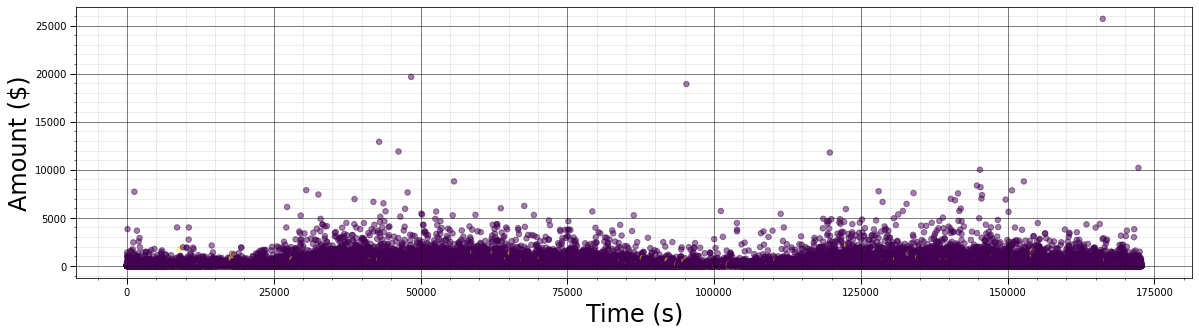

In [ ]:
plot_scatter(df_credit[['Time','Amount','Class']],categorycolor=True,pointsize=30,xlabel='Time (s)',ylabel='Amount ($)') 

In [ ]:
df_credit[['Time','Amount','Class']].values

array([[0.00000e+00, 1.49620e+02, 0.00000e+00],
       [0.00000e+00, 2.69000e+00, 0.00000e+00],
       [1.00000e+00, 3.78660e+02, 0.00000e+00],
       ...,
       [1.72788e+05, 6.78800e+01, 0.00000e+00],
       [1.72788e+05, 1.00000e+01, 0.00000e+00],
       [1.72792e+05, 2.17000e+02, 0.00000e+00]])

Zoom in, com objetivo de melhorar visualização

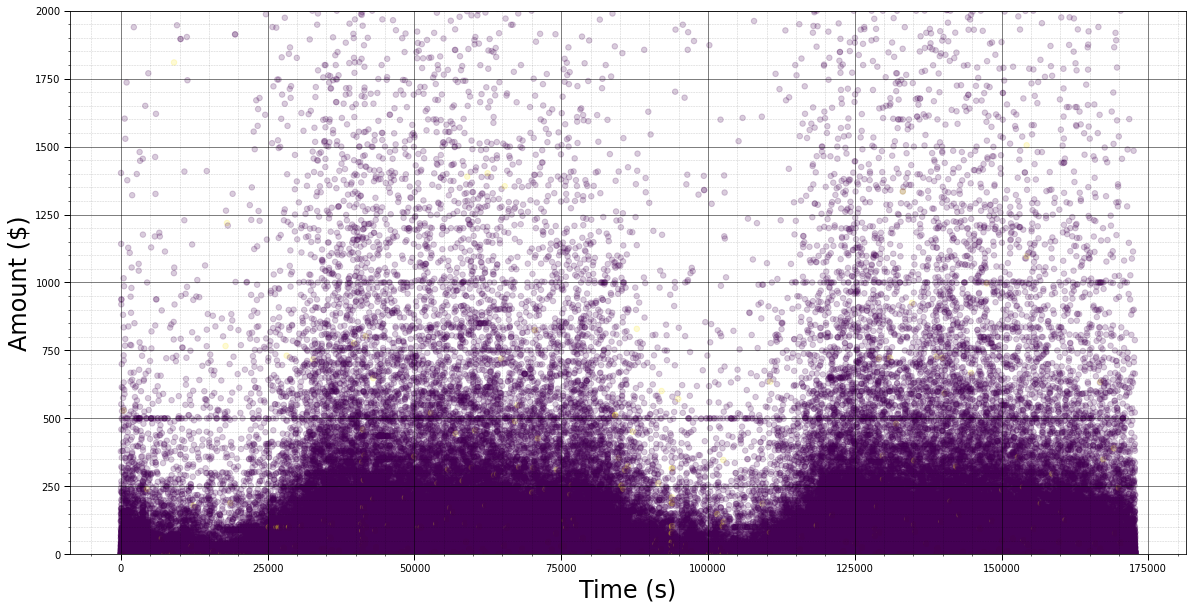

In [ ]:
plot_scatter(df_credit[['Time','Amount','Class']],categorycolor=True,pointsize=30,ylim=(0,2000),
             transparency=.2,size=(20,10),xlabel='Time (s)',ylabel='Amount ($)') # Zoom in, aprimorar visualização

### Histogramas / Distribuição de frequências V1, V2 ... V28
Para todas as variáveis alteradas, é realizado impressão de histogramas com objetivo de visualizar como elas estão distribuidas, filtrando como consumidores normais e fraudulentos


---



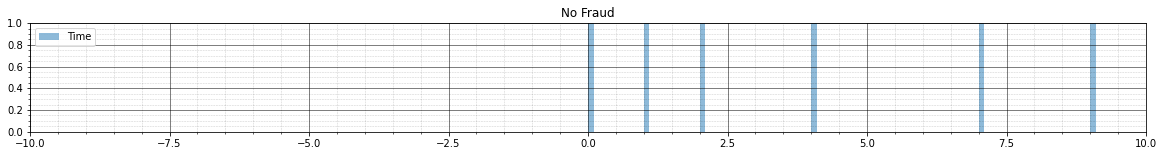

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


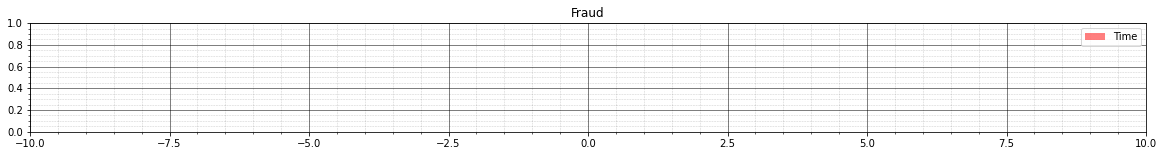

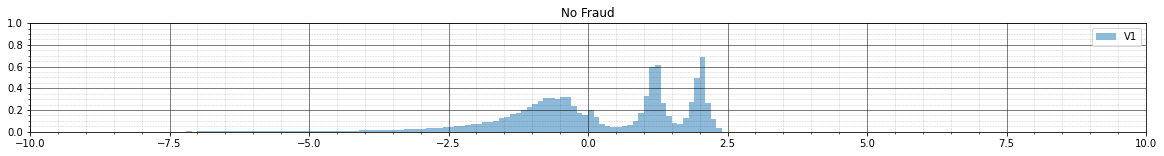

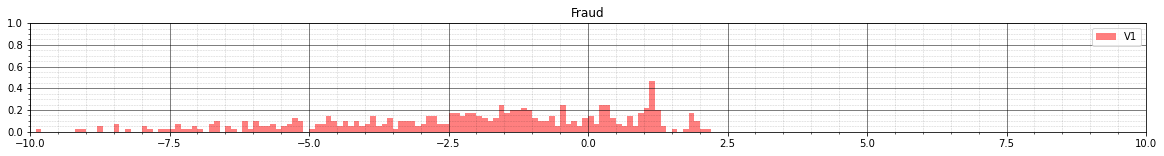

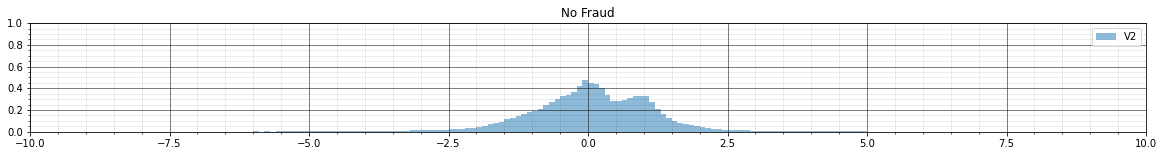

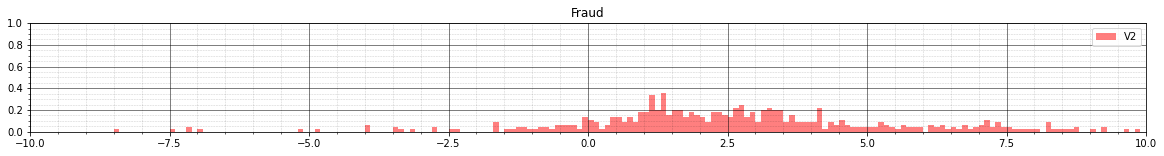

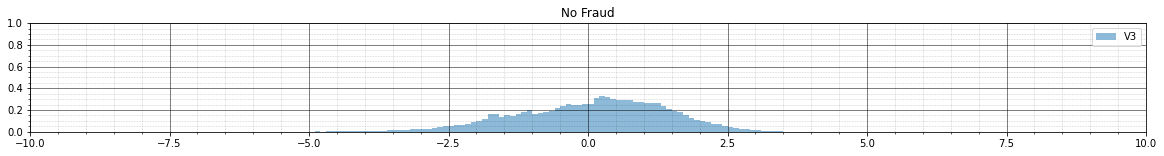

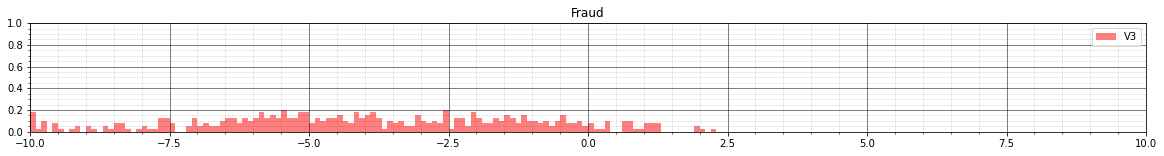

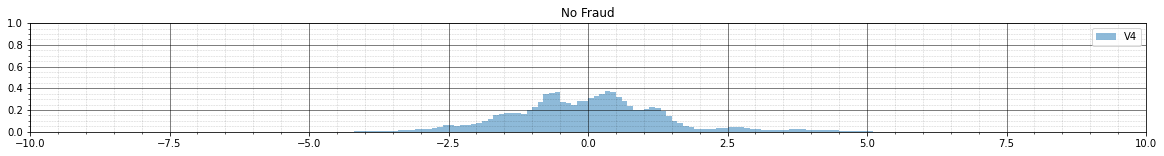

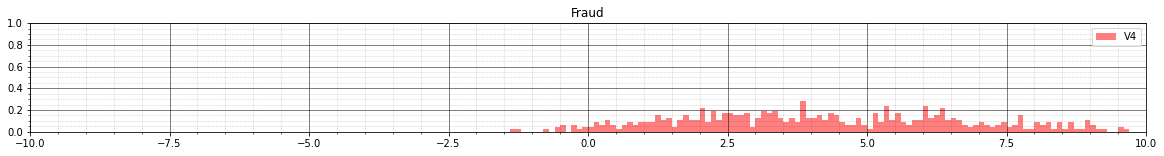

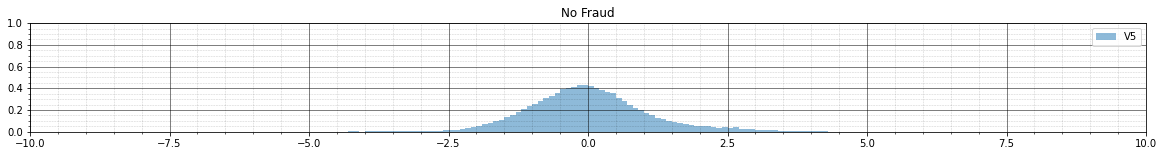

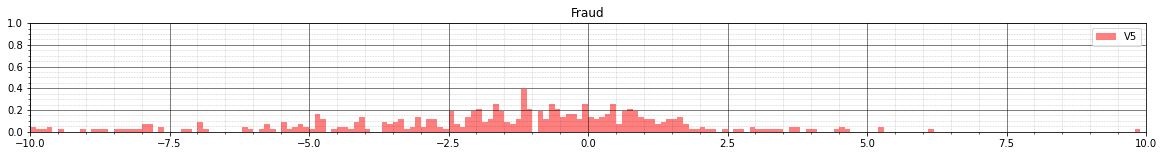

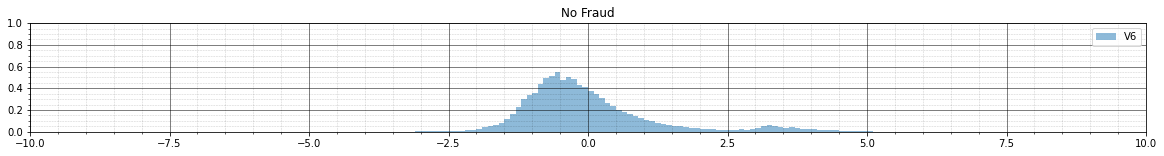

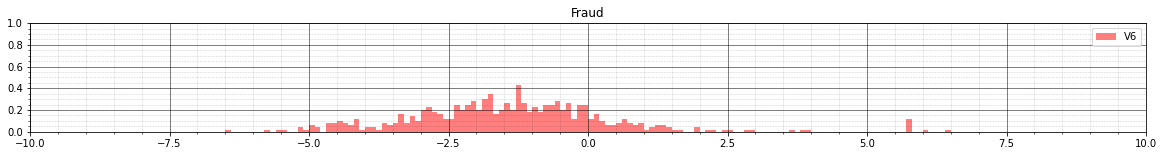

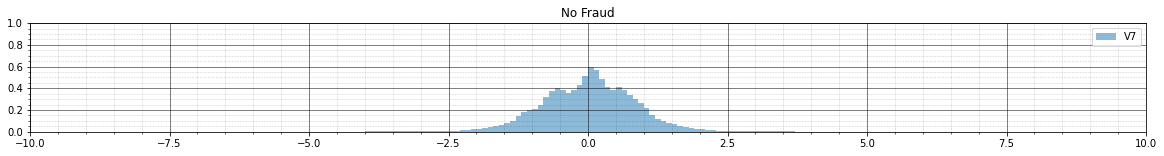

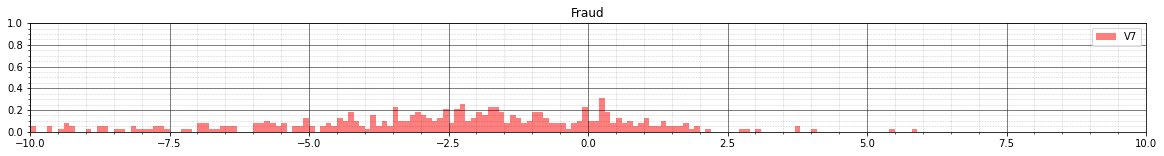

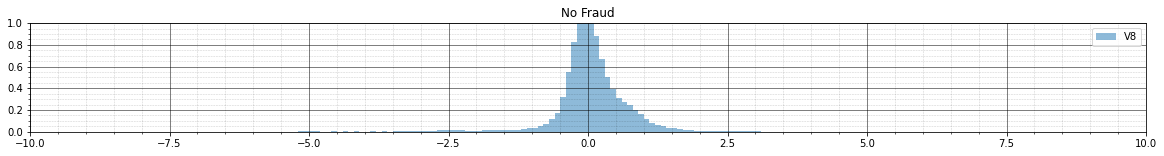

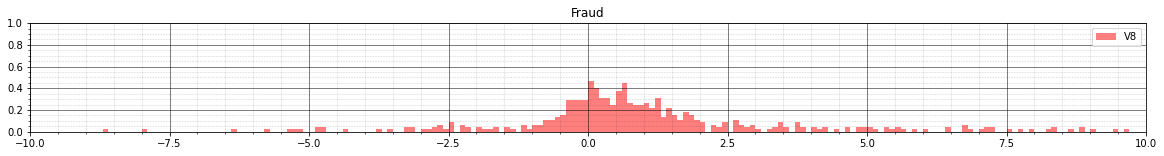

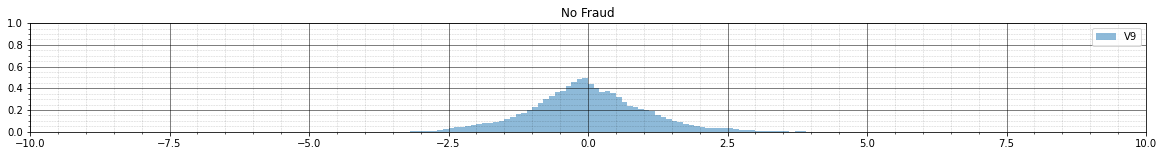

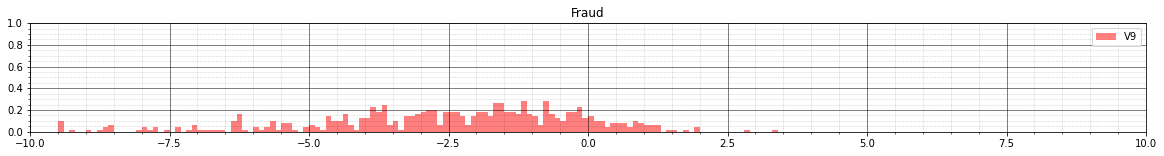

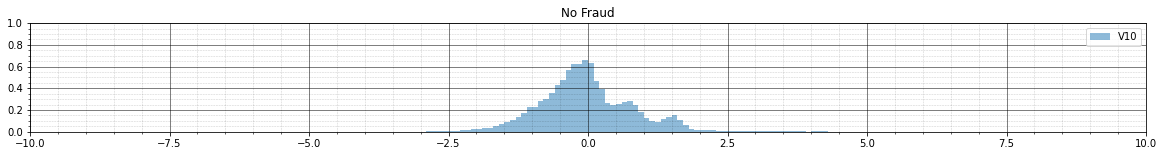

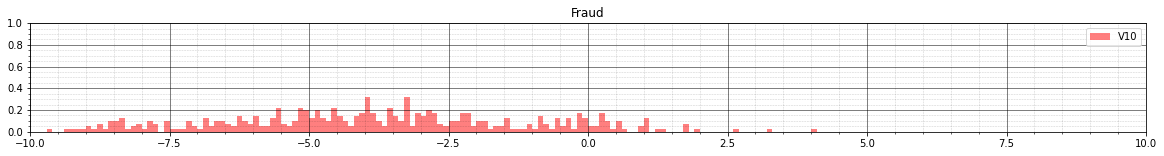

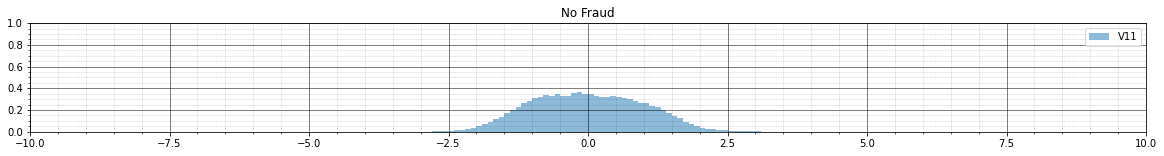

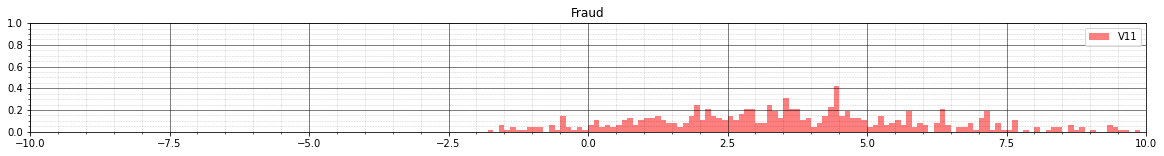

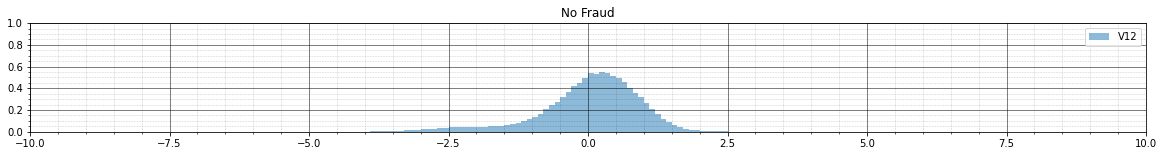

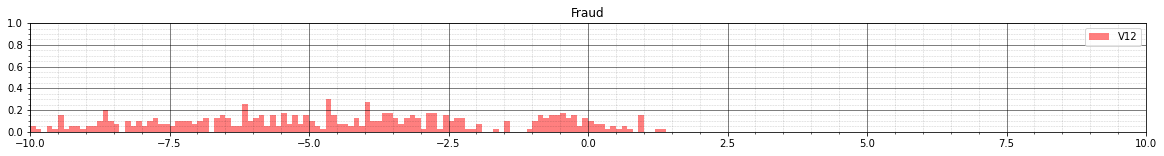

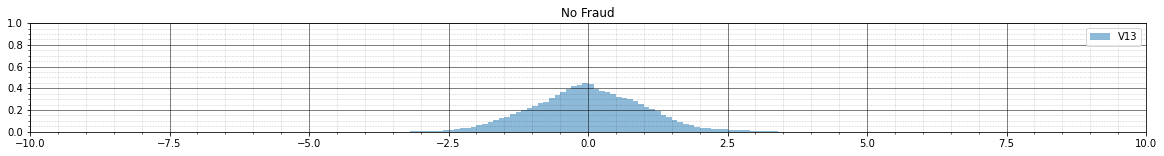

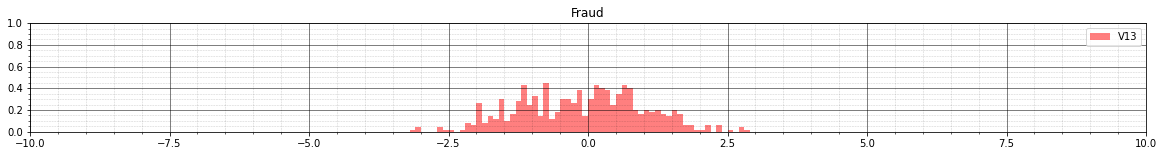

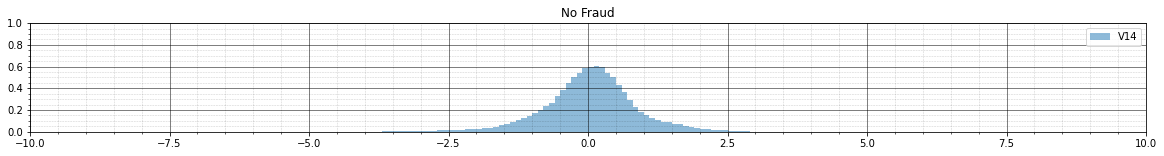

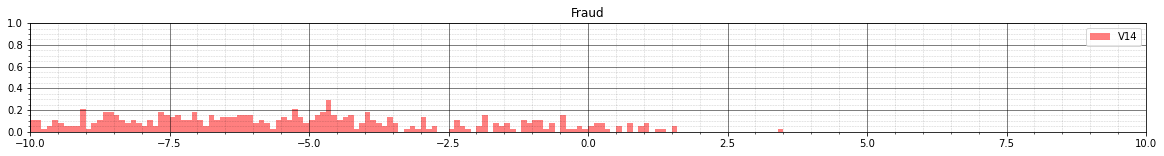

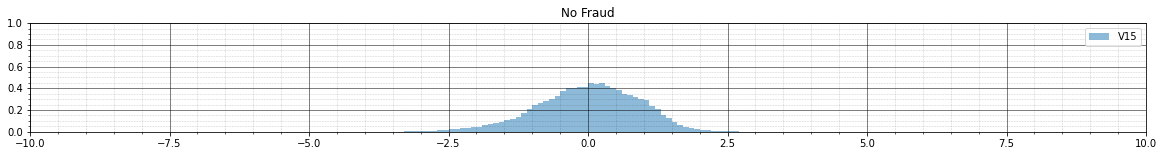

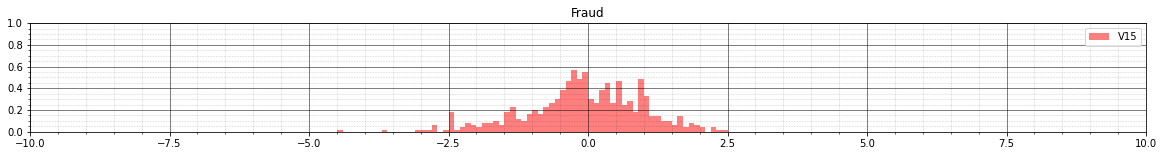

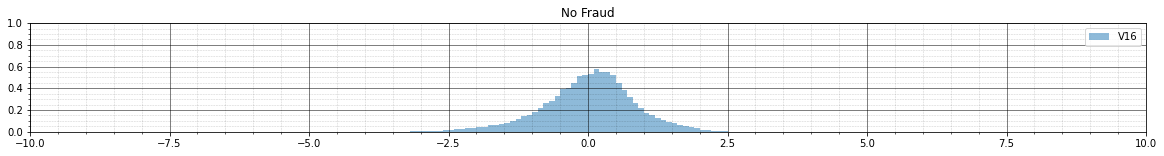

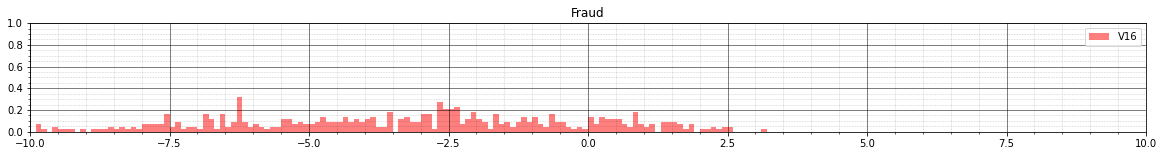

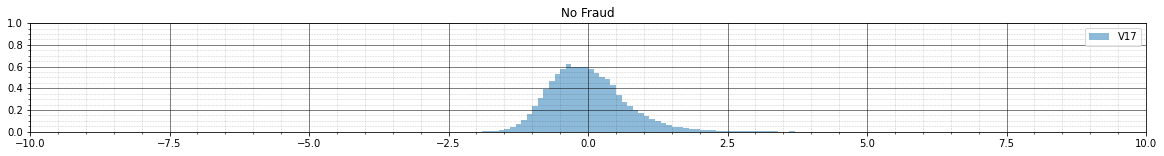

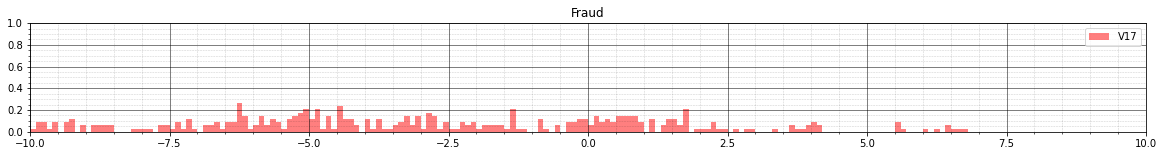

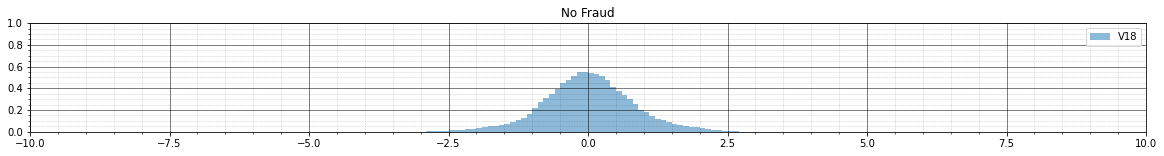

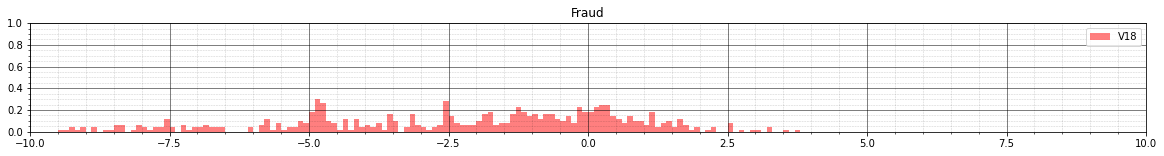

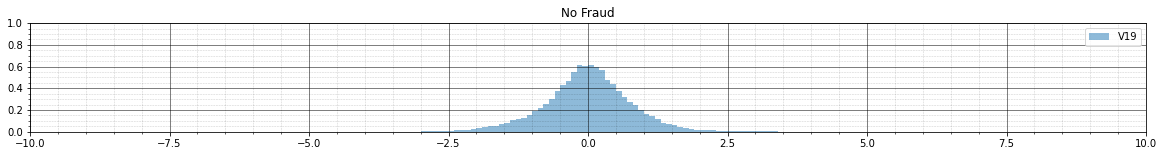

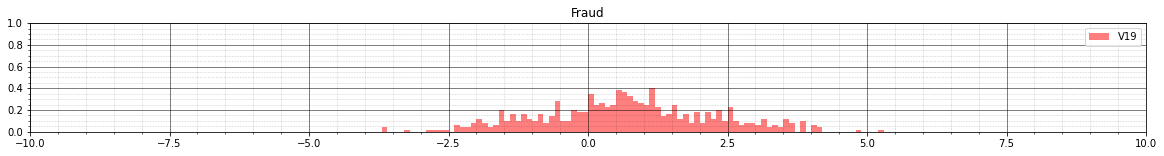

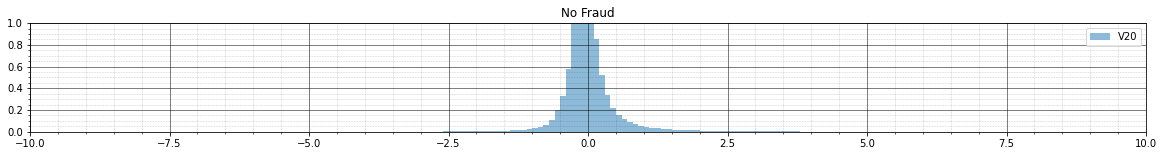

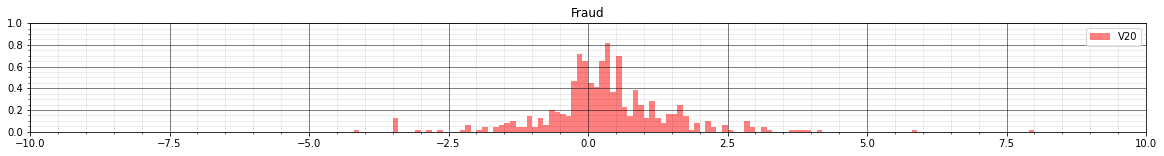

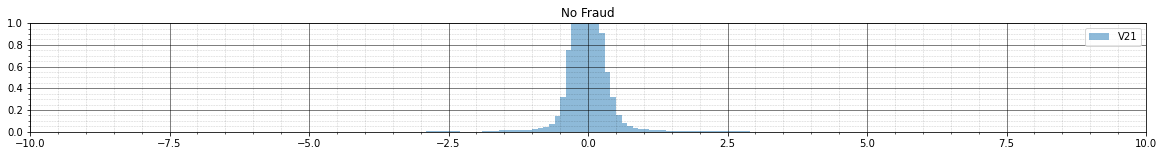

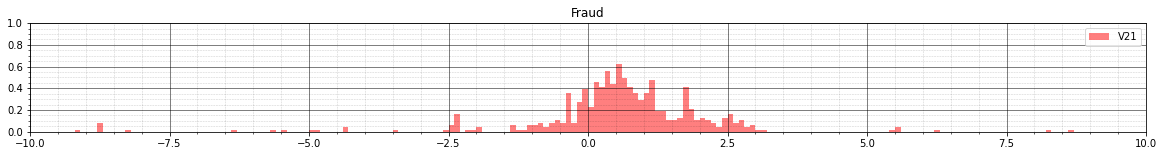

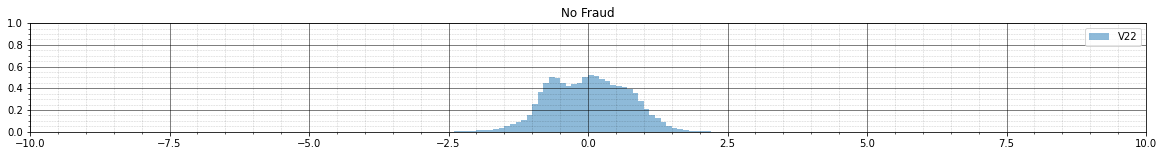

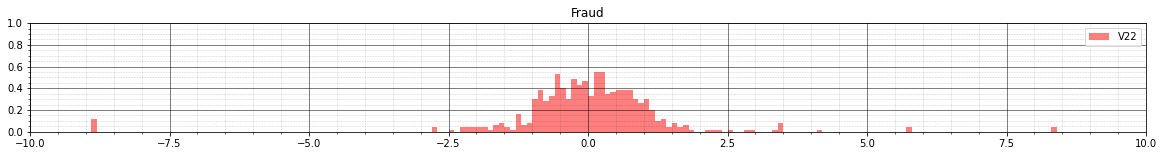

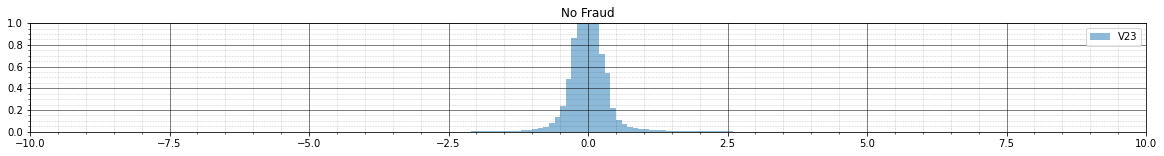

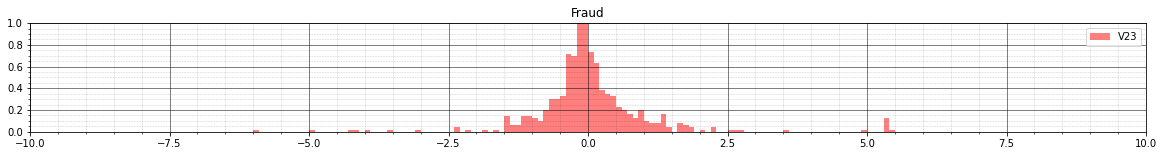

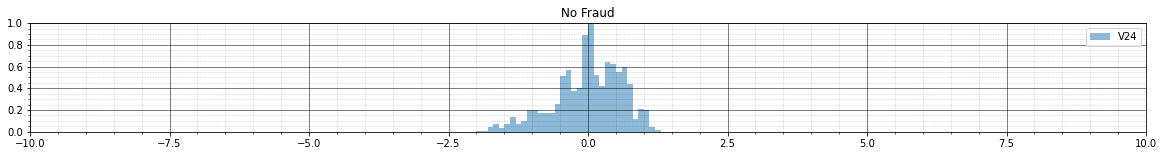

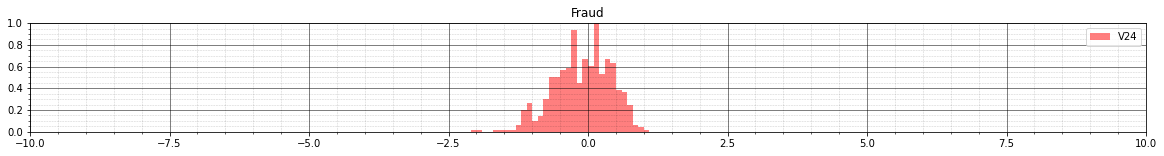

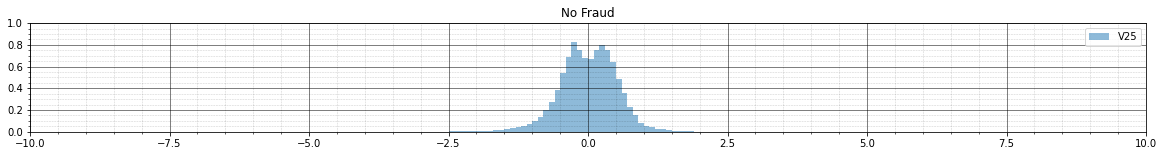

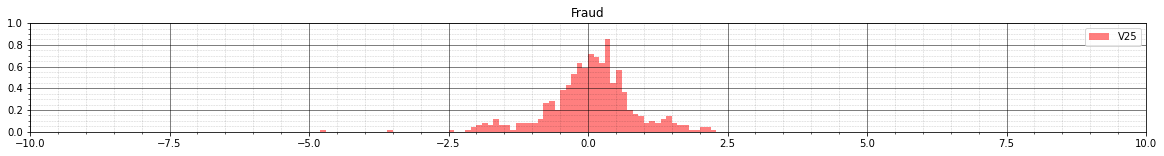

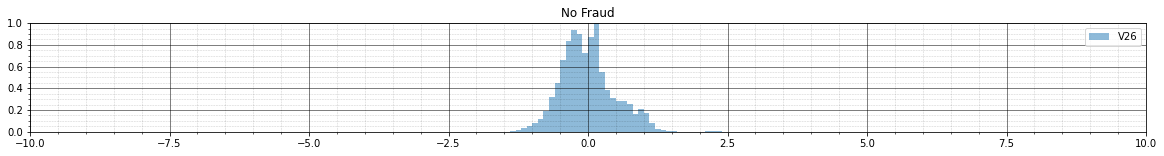

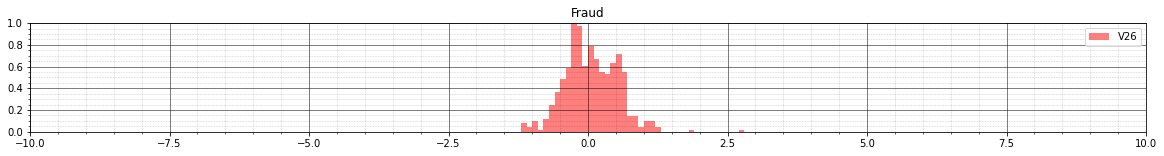

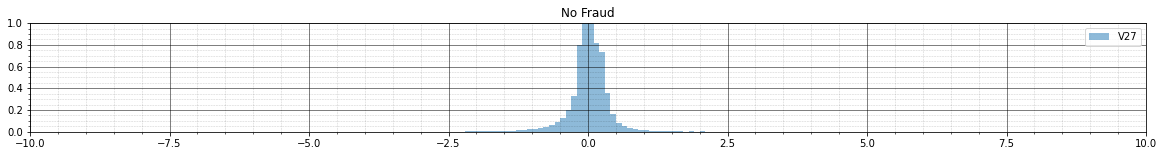

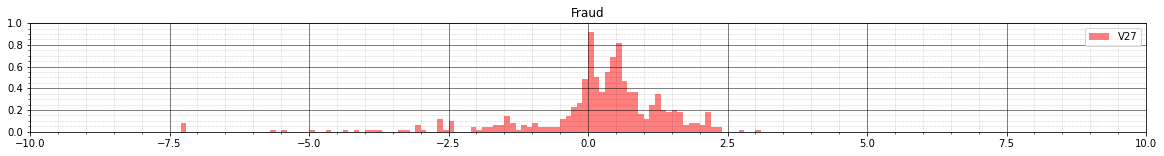

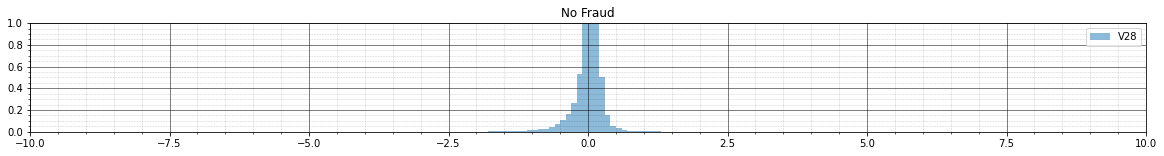

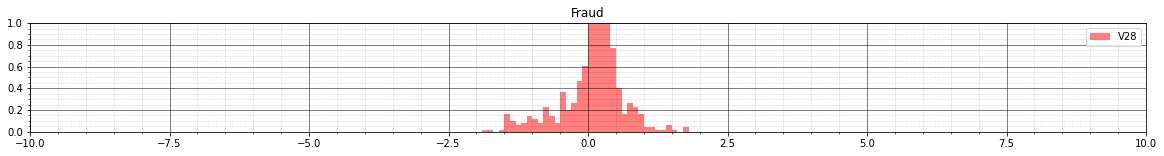

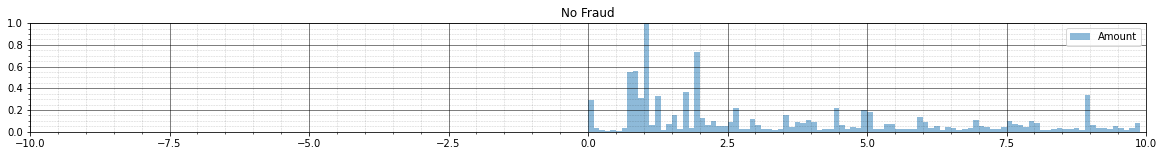

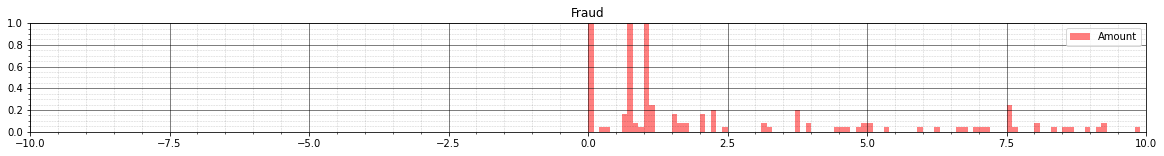

In [ ]:
for column in df_credit.iloc[:,0:30]:
  plot_histograma(data=df_credit[[column]].loc[df_credit['Class']==0],
                  xlim=(-10,10),ylim=(0,1),size=(20,2),bins=np.arange(-10, 10, .1),
                  density=True,title='No Fraud',labelfontsize=12)
  plot_histograma(data=df_credit[[column]].loc[df_credit['Class']==1],
                  xlim=(-10,10),ylim=(0,1),size=(20,2),bins=np.arange(-10, 10, .1),
                  density=True,title='Fraud',color='red',labelfontsize=12)

### BoxPlot das váriaveis V1 ~ V28

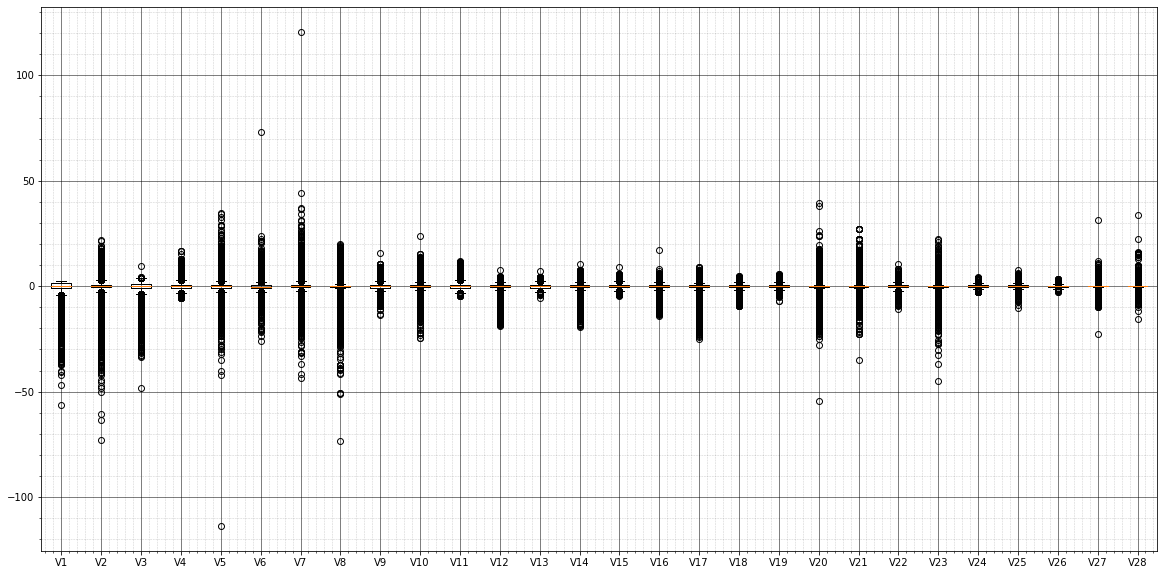

In [ ]:
plot_boxplot(df_credit.iloc[:,1:29],size=(20,10))


### Filtrando as operações fraudulentas e regulares


In [ ]:
df_credit.loc[(df_credit["Class"] == 0)].describe()\
              .style.set_table_styles(stylepattern).applymap(positiveandnegative_colors) # Descrição do Dataframe filtrando operações fraudulentas

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000
mean,94838.2023,0.0083,-0.0063,0.0122,-0.0079,0.0055,0.0024,0.0096,-0.0010,0.0045,0.0098,-0.0066,0.0108,0.0002,0.0121,0.0002,0.0072,0.0115,0.0039,-0.0012,-0.0006,-0.0012,-0.0000,0.0001,0.0002,-0.0001,-0.0001,-0.0003,-0.0001,88.2910,0.0000
std,47484.0158,1.9298,1.6361,1.4594,1.3993,1.3570,1.3299,1.1788,1.1613,1.0894,1.0442,1.0031,0.9459,0.9951,0.8970,0.9151,0.8448,0.7495,0.8249,0.8117,0.7694,0.7167,0.7237,0.6215,0.6058,0.5207,0.4822,0.3998,0.3296,250.1051,0.0000
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-31.7649,-73.2167,-6.2907,-14.7411,-4.7975,-15.1450,-5.7919,-18.3921,-4.3913,-10.1156,-17.0984,-5.3667,-7.2135,-54.4977,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54230.0000,-0.9175,-0.5995,-0.8845,-0.8501,-0.6894,-0.7668,-0.5514,-0.2086,-0.6404,-0.5329,-0.7634,-0.4021,-0.6481,-0.4225,-0.5828,-0.4655,-0.4826,-0.4974,-0.4564,-0.2118,-0.2285,-0.5424,-0.1617,-0.3544,-0.3171,-0.3271,-0.0709,-0.0529,5.6500,0.0000
50%,84711.0000,0.0200,0.0641,0.1822,-0.0224,-0.0535,-0.2731,0.0411,0.0220,-0.0500,-0.0919,-0.0349,0.1417,-0.0135,0.0519,0.0483,0.0674,-0.0648,-0.0028,0.0031,-0.0626,-0.0298,0.0067,-0.0111,0.0411,0.0164,-0.0522,0.0012,0.0112,22.0000,0.0000
75%,139333.0000,1.3162,0.8004,1.0284,0.7376,0.6122,0.3996,0.5710,0.3262,0.5982,0.4551,0.7364,0.6192,0.6625,0.4941,0.6488,0.5237,0.3999,0.5011,0.4575,0.1324,0.1856,0.5284,0.1475,0.4399,0.3506,0.2407,0.0906,0.0780,77.0500,0.0000
max,172792.0000,2.4549,18.9025,9.3826,16.8753,34.8017,73.3016,120.5895,18.7093,15.5950,23.7451,10.0022,7.8484,7.1269,10.5268,8.8777,17.3151,9.2535,5.0411,5.5920,39.4209,22.6149,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,0.0000


In [ ]:
df_credit.loc[(df_credit["Class"] == 1)].describe()\
                .style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000
mean,80746.8069,-4.7719,3.6238,-7.0333,4.5420,-3.1512,-1.3977,-5.5687,0.5706,-2.5811,-5.6769,3.8002,-6.2594,-0.1093,-6.9717,-0.0929,-4.1399,-6.6658,-2.2463,0.6807,0.3723,0.7136,0.0140,-0.0403,-0.1051,0.0414,0.0516,0.1706,0.0757,122.2113,1.0000
std,47835.3651,6.7837,4.2912,7.1109,2.8733,5.3725,1.8581,7.2068,6.7978,2.5009,4.8973,2.6786,4.6545,1.1045,4.2789,1.0499,3.8650,6.9706,2.8994,1.5399,1.3466,3.8693,1.4946,1.5796,0.5156,0.7972,0.4717,1.3768,0.5473,256.6833,0.0000
min,406.0000,-30.5524,-8.4022,-31.1037,-1.3133,-22.1055,-6.4063,-43.5572,-41.0443,-13.4341,-24.5883,-1.7022,-18.6837,-3.1278,-19.2143,-4.4989,-14.1299,-25.1628,-9.4987,-3.6819,-4.1282,-22.7976,-8.8870,-19.2543,-2.0280,-4.7816,-1.1527,-7.2635,-1.8693,0.0000,1.0000
25%,41241.5000,-6.0361,1.1882,-8.6435,2.3730,-4.7928,-2.5015,-7.9653,-0.1953,-3.8724,-7.7567,1.9734,-8.6882,-0.9791,-9.6927,-0.6435,-6.5629,-11.9451,-4.6646,-0.2994,-0.1718,0.0418,-0.5338,-0.3422,-0.4368,-0.3143,-0.2594,-0.0200,-0.1089,1.0000,1.0000
50%,75568.5000,-2.3425,2.7179,-5.0753,4.1771,-1.5230,-1.4246,-3.0344,0.6215,-2.2088,-4.5788,3.5862,-5.5025,-0.0656,-6.7297,-0.0572,-3.5498,-5.3029,-1.6643,0.6468,0.2847,0.5921,0.0484,-0.0731,-0.0608,0.0884,0.0043,0.3949,0.1463,9.2500,1.0000
75%,128483.0000,-0.4192,4.9713,-2.2762,6.3487,0.2146,-0.4132,-0.9460,1.7649,-0.7879,-2.6142,5.3071,-2.9741,0.6730,-4.2828,0.6092,-1.2260,-1.3419,0.0918,1.6493,0.8224,1.2446,0.6175,0.3084,0.2853,0.4565,0.3967,0.8260,0.3812,105.8900,1.0000
max,170348.0000,2.1324,22.0577,2.2502,12.1147,11.0951,6.4741,5.8025,20.0072,3.3535,4.0314,12.0189,1.3759,2.8154,3.4424,2.4714,3.1397,6.7394,3.7903,5.2283,11.0590,27.2028,8.3620,5.4662,1.0914,2.2082,2.7453,3.0524,1.7794,2125.8700,1.0000


### Visualizando Time x Amount de operações fraudulentas e regulares

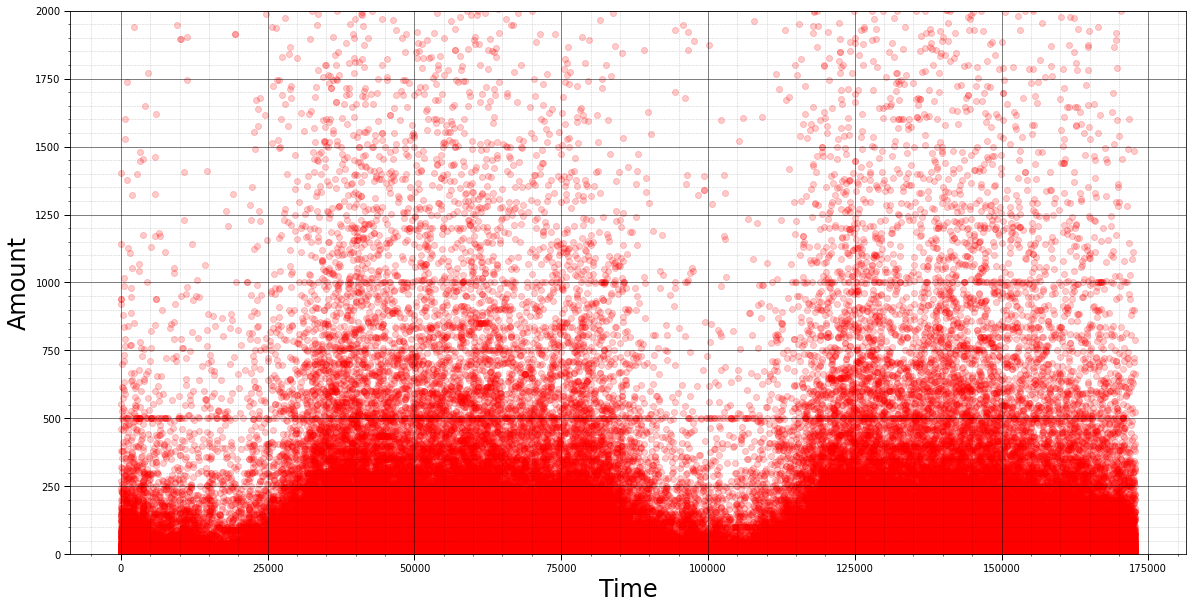

In [ ]:
plot_scatter(df_credit[['Time','Amount']].loc[df_credit['Class']==0],pointsize=30,ylim=(0,2000),transparency=.2,size=(20,10))

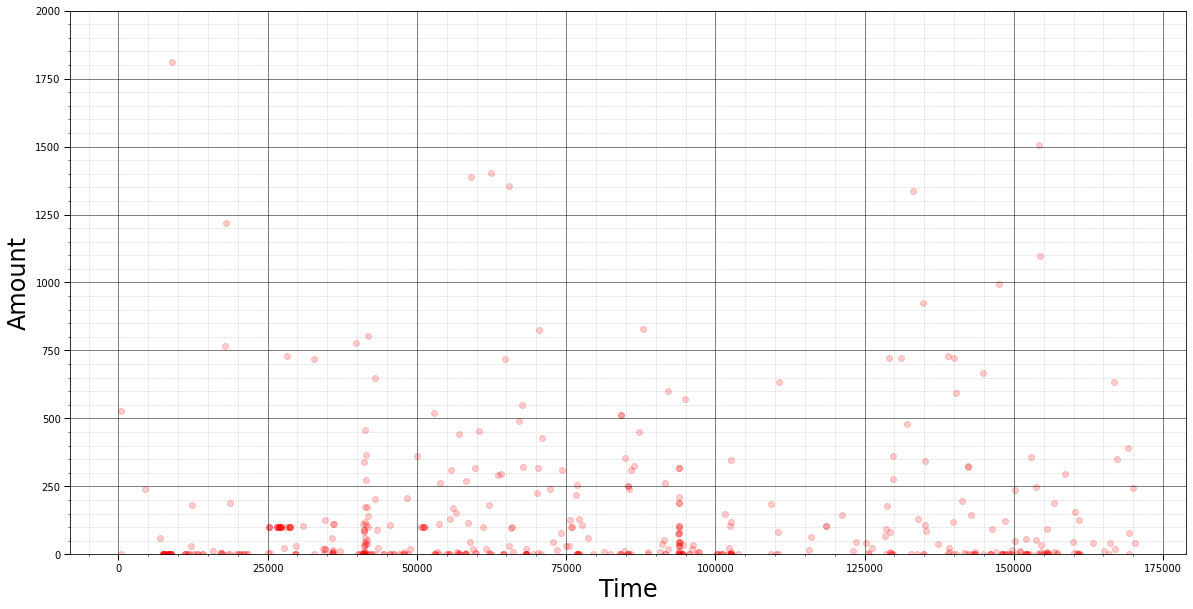

In [ ]:
plot_scatter(df_credit[['Time','Amount']].loc[df_credit['Class']==1],pointsize=30,ylim=(0,2000),transparency=.2,size=(20,10))

In [ ]:
df_credit.corr().style.set_table_styles(stylepattern).background_gradient(cmap='Purples').applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Time,1.0000,0.1174,-0.0106,-0.4196,-0.1053,0.1731,-0.0630,0.0847,-0.0369,-0.0087,0.0306,-0.2477,0.1243,-0.0659,-0.0988,-0.1835,0.0119,-0.0733,0.0904,0.0290,-0.0509,0.0447,0.1441,0.0511,-0.0162,-0.2331,-0.0414,-0.0051,-0.0094,-0.0106,-0.0123
V1,0.1174,1.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.2277,-0.1013
V2,-0.0106,0.0000,1.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.5314,0.0913
V3,-0.4196,-0.0000,0.0000,1.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.2109,-0.1930
V4,-0.1053,0.0000,-0.0000,-0.0000,1.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0987,0.1334
V5,0.1731,0.0000,-0.0000,-0.0000,-0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.3864,-0.0950
V6,-0.0630,0.0000,0.0000,0.0000,-0.0000,0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.2160,-0.0436
V7,0.0847,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,1.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.3973,-0.1873
V8,-0.0369,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,1.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.1031,0.0199




### Soma, média, desvio padrão e variancia dos valores monetário das operações legítimas (0) e fraudulentas (1).

In [ ]:
pd.pivot_table(df_credit,index='Class',values='Amount',aggfunc=['mean','sum','std','var'],margins=True,margins_name='Total')\
            .style.set_table_styles(stylepattern)

,mean,sum,std,var
Features,Amount,Amount,Amount,Amount
Class,,,,
0,88.2910,25102462.0400,250.1051,62552.5572
1,122.2113,60127.9700,256.6833,65886.3105
Total,88.3496,25162590.0100,250.1201,62560.0690


### APRENDIZADO DE MÁQUINA E TUNNING

In [ ]:
#sc = StandardScaler()
#df_credit.Amount = sc.fit_transform(df_credit.Amount.values.reshape(-1, 1))
#df_credit.drop(columns='Time',inplace=True)

In [ ]:
#plot_boxplot(df_credit,size=(20,10))
